In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import scipy.io
import datetime
import dateutil
import numpy as np
import pandas as pd
import cv2
import sklearn.model_selection
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
import shutil
import time

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
IMDB_SOURCE_DIR = 'imdb_crop'
IMDB_MATDB_FILE = os.path.join(IMDB_SOURCE_DIR, 'imdb.mat')
IMAGE_OUTPUT_DIR = 'image_output'
IMAGE_SIZE_PIXELS = 224
MODEL_CHECKPOINT_DIR = 'model_checkpoint'

In [3]:
matdb = scipy.io.loadmat(IMDB_MATDB_FILE)['imdb'][0, 0]
print('MATLIB database rows: {}'.format(str(len(matdb["face_score"][0]))))

MATLIB database rows: 460723


In [4]:
def calculate_age(dob, photo_taken_year):
    days = dob % 1
    birth_date = datetime.date.fromordinal(dob) + datetime.timedelta(days=days) - datetime.timedelta(days=366)
    return dateutil.relativedelta.relativedelta(datetime.date(photo_taken_year, 7, 1), birth_date).years

In [5]:
def get_age_range_id(age):
    if age < 18:
        return 0
    if age <= 24:
        return 1
    if age <= 34:
        return 2
    if age <= 44:
        return 3
    if age <= 54:
        return 4
    if age <= 64:
        return 5
    if age < 75:
        return 6
    return 7


def get_age_range_name(age_range_id):
    if age_range_id == 0:
        return '< 18'
    if age_range_id == 1:
        return '18 - 24'
    if age_range_id == 2:
        return '25 - 34'
    if age_range_id == 3:
        return '35 - 44'
    if age_range_id == 4:
        return '45 - 54'
    if age_range_id == 5:
        return '55 - 64'
    if age_range_id == 6:
        return '65 - 74'
    return '75+'

def get_gender_name(gender):
    if gender == 0:
        return 'Female'
    if gender == 1:
        return 'Male'
    return 'Unknown'

In [6]:
rows = []
MINIMUM_FACE_SCORE = 2.0

for i in range(len(matdb["face_score"][0])):
    dob = int(matdb["dob"][0][i])
    face_score = matdb["face_score"][0][i]
    second_face_score = matdb["second_face_score"][0][i]

    if dob <= 366:
        continue

    if face_score < MINIMUM_FACE_SCORE or np.isinf(face_score):
        continue
        
    if (~np.isnan(second_face_score)) and second_face_score > 0.0:
        continue

    file_path = matdb["full_path"][0][i][0]
    age = calculate_age(dob, int(matdb["photo_taken"][0][i]))
    gender = matdb["gender"][0][i]
    if os.path.isfile(os.path.join(IMDB_SOURCE_DIR, file_path)):
        rows.append({'file_path': file_path, 'age': age, 'age_range_id': get_age_range_id(age), 'gender': gender})
    else:
        print('Image file does not exist! Skipping record for image: {}'.format(file_path))


df = pd.DataFrame(rows, columns=['file_path', 'age', 'age_range_id', 'gender'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136768 entries, 0 to 136767
Data columns (total 4 columns):
file_path       136768 non-null object
age             136768 non-null int64
age_range_id    136768 non-null int64
gender          134498 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.2+ MB


In [7]:
df = df.drop_duplicates()
df = df.dropna()
df = df.astype({'gender': 'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134498 entries, 0 to 136767
Data columns (total 4 columns):
file_path       134498 non-null object
age             134498 non-null int64
age_range_id    134498 non-null int64
gender          134498 non-null int64
dtypes: int64(3), object(1)
memory usage: 5.1+ MB


In [8]:
df.head()

,file_path,age,age_range_id,gender
0,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,79,7,0
1,02/nm0000002_rm1363385088_1924-9-16_2004.jpg,79,7,0
2,02/nm0000002_rm221957120_1924-9-16_1974.jpg,49,4,0
3,02/nm0000002_rm2287049216_1924-9-16_2007.jpg,82,7,0
4,02/nm0000002_rm238734336_1924-9-16_1974.jpg,49,4,0


In [9]:
df.describe()

,age,age_range_id,gender
count,134498.000000,134498.000000,134498.000000
mean,36.055183,2.634998,0.518119
std,12.969357,1.351856,0.499673
min,-30.000000,0.000000,0.000000
25%,27.000000,2.000000,0.000000
50%,34.000000,2.000000,1.000000
75%,43.000000,3.000000,1.000000
max,134.000000,7.000000,1.000000


In [10]:
df.drop(df[ df.age < 13 ].index, inplace=True)
df.drop(df[ df.age > 80 ].index, inplace=True)
df.describe()

,age,age_range_id,gender
count,132077.000000,132077.000000,132077.000000
mean,36.315225,2.660986,0.519031
std,12.307695,1.301717,0.499640
min,13.000000,0.000000,0.000000
25%,27.000000,2.000000,0.000000
50%,35.000000,3.000000,1.000000
75%,43.000000,3.000000,1.000000
max,80.000000,7.000000,1.000000


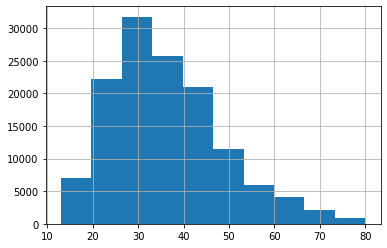

In [11]:
df['age'].hist()

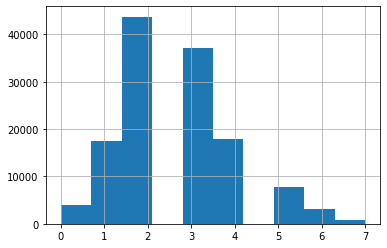

In [12]:
df['age_range_id'].hist()

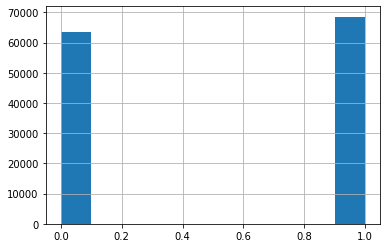

In [13]:
df['gender'].hist()

In [14]:
gender_summary_df = df.groupby(by=['gender'])['age'].count().to_frame('count').reset_index()

for index, row in gender_summary_df.iterrows():
    print('{}\t{}'.format(get_gender_name(row['gender']), row['count']))

Female	63525
Male	68552


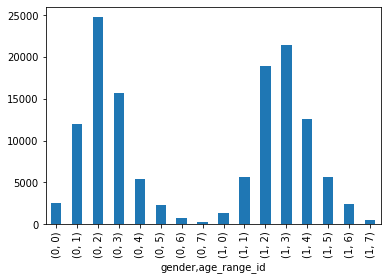

In [15]:
df.groupby(by=['gender', 'age_range_id'])['age'].count().plot(kind='bar')

In [16]:
age_range_summary_df = df.groupby(by=['gender', 'age_range_id'])['age'].count().to_frame('count').reset_index()

for index, row in age_range_summary_df.iterrows():
    print('{}\t{}\t{}'.format(get_gender_name(row['gender']), get_age_range_name(row['age_range_id']), row['count']))

Female	< 18	2568
Female	18 - 24	11954
Female	25 - 34	24771
Female	35 - 44	15662
Female	45 - 54	5346
Female	55 - 64	2264
Female	65 - 74	727
Female	75+	233
Male	< 18	1375
Male	18 - 24	5641
Male	25 - 34	18975
Male	35 - 44	21457
Male	45 - 54	12626
Male	55 - 64	5585
Male	65 - 74	2366
Male	75+	527


In [17]:
for file_path in df.file_path.values:
    source_file_path = os.path.join(IMDB_SOURCE_DIR, file_path)
    if not os.path.exists(source_file_path):
        print('Missing Source Photo! File: {}'.format(source_file_path))

    output_file_path = os.path.join(IMAGE_OUTPUT_DIR, file_path)
    if not os.path.exists(os.path.dirname(output_file_path)):
        os.makedirs(os.path.dirname(output_file_path))

    image = cv2.imread(source_file_path)
    crop = cv2.resize(image, (IMAGE_SIZE_PIXELS, IMAGE_SIZE_PIXELS))
    cv2.imwrite(output_file_path, crop)

In [18]:
train_df = None
validation_df = None
test_df = None

for age_range_id in df.age_range_id.unique():
    split_df, tmp_test_df = sklearn.model_selection.train_test_split(df[df.age_range_id == age_range_id],
                                                                      test_size=0.1)
    tmp_train_df, tmp_validation_df = sklearn.model_selection.train_test_split(split_df, test_size=0.2)
    
    if train_df is None:
        train_df = tmp_train_df.copy(deep=True)
    else:
        train_df = train_df.append(tmp_train_df, ignore_index=True)
        
    if validation_df is None:
        validation_df = tmp_validation_df.copy(deep=True)
    else:
        validation_df = validation_df.append(tmp_validation_df, ignore_index=True)

    if test_df is None:
        test_df = tmp_test_df.copy(deep=True)
    else:
        test_df = test_df.append(tmp_test_df, ignore_index=True)

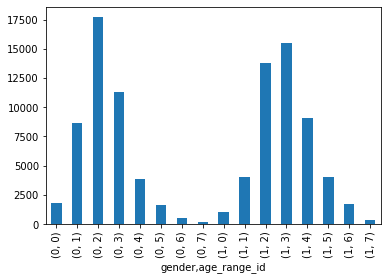

In [19]:
train_df.groupby(by=['gender', 'age_range_id'])['age'].count().plot(kind='bar')

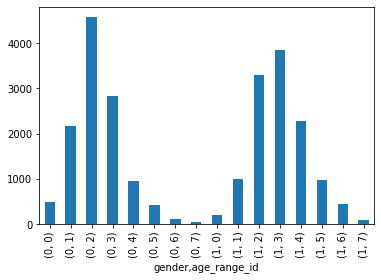

In [20]:
validation_df.groupby(by=['gender', 'age_range_id'])['age'].count().plot(kind='bar')

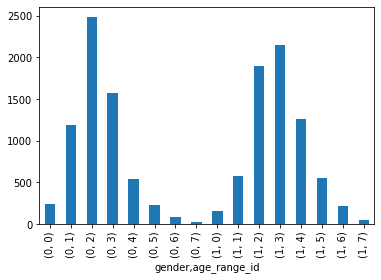

In [21]:
test_df.groupby(by=['gender', 'age_range_id'])['age'].count().plot(kind='bar')

In [22]:
print('# of rows in Training data set: {}'.format(len(train_df.index)))

# of rows in Training data set: 95090


In [23]:
print('# of rows in Validation data set: {}'.format(len(validation_df.index)))

# of rows in Validation data set: 23776


In [24]:
print('# of rows in Test data set: {}'.format(len(test_df.index)))

# of rows in Test data set: 13211


In [25]:
train_df.to_csv('train.csv', index=False)
validation_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [26]:
input_layer = layers.Input(shape=(IMAGE_SIZE_PIXELS, IMAGE_SIZE_PIXELS, 3))
layer = layers.Conv2D(filters=32, kernel_size=3)(input_layer)
layer = layers.Conv2D(filters=32*2, kernel_size=3)(layer)
layer = layers.Conv2D(filters=32*3, kernel_size=3)(layer)
layer = layers.Conv2D(filters=32*4, kernel_size=3)(layer)
bottleneck = layers.GlobalMaxPool2D()(layer)

In [27]:
layer = layers.Dense(units=128)(bottleneck)
layer = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(layer)
layer = layers.Dropout(0.3)(layer)
layer = layers.Dense(units=128, activation='relu')(layer)
age_output = layers.Dense(units=8, activation='softmax', name='age_output')(layer)

In [28]:
layer = layers.Dense(units=128)(bottleneck)
layer = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(layer)
layer = layers.Dropout(0.3)(layer)
layer = layers.Dense(units=128, activation='relu')(layer)
gender_output = layers.Dense(units=2, activation='softmax', name='gender_output')(layer)

In [29]:
model = tf.keras.Model(inputs=input_layer, outputs=[age_output, gender_output])
model.compile(optimizer='adam', 
              loss={'age_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2.0, 'gender_output': 1.0},
              metrics={'age_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 218, 218, 96) 55392       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [30]:
if os.path.isdir(MODEL_CHECKPOINT_DIR):
    shutil.rmtree(MODEL_CHECKPOINT_DIR, ignore_errors=True)

os.makedirs(MODEL_CHECKPOINT_DIR)
    
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_CHECKPOINT_DIR, monitor='val_loss')
]

In [31]:
def get_data_generator(df, image_dir, for_training, batch_size=16):
    images, ages, genders = [], [], []
    while True:
        for index, row in df.iterrows():
            file_path, age_range_id, gender = row['file_path'], row['age_range_id'], row['gender']
            im = Image.open(os.path.join(image_dir, file_path))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(tf.keras.utils.to_categorical(age_range_id, 8))
            genders.append(tf.keras.utils.to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
        if not for_training:
            break

In [32]:
BATCH_SIZE = 16
EPOCHS = 1

train_gen = get_data_generator(train_df, IMAGE_OUTPUT_DIR, for_training=True, batch_size=BATCH_SIZE)
validation_gen = get_data_generator(validation_df, IMAGE_OUTPUT_DIR, for_training=True, batch_size=BATCH_SIZE)

In [33]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_df)//BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=validation_gen,
                    validation_steps=len(validation_df)//BATCH_SIZE)

5943/5943 [==============================] - 1626s 274ms/step - loss: 6.2849 - age_output_loss: 2.8045 - gender_output_loss: 0.6760 - age_output_accuracy: 0.8247 - gender_output_accuracy: 0.6142 - val_loss: 23.9258 - val_age_output_loss: 11.5883 - val_gender_output_loss: 0.7493 - val_age_output_accuracy: 0.2810 - val_gender_output_accuracy: 0.4886


In [34]:
export_path_keras = '{}.h5'.format(int(time.time()))
print('Saving model as: {}'.format(export_path_keras))
model.save(export_path_keras)

Saving model as: 1582951634.h5
